In [2]:
%config InlineBackend.figure_format = 'retina'
%pylab inline
import sys
sys.path.insert(1, '../codes/')
from geeCodes import *


import ee
#earthengine authenticate
ee.Authenticate()
ee.Initialize()

Populating the interactive namespace from numpy and matplotlib


Enter verification code: 4/1AWtgzh7vw5Vj5Hf8NEg1S63SbFX0OEVBH9OFZl7P-TuSU16B4m2gj62qjIU

Successfully saved authorization token.


In [3]:
dfc = gpd.read_file('../data_revision/cities/all/gdfCities.shp')
dfc = dfc.to_crs("EPSG:4326")
cities = dfc['UC_NM_MN']
years_str = []
years = np.arange(2010,2021)
for y in years:
    years_str.append(str(y))

In [4]:
dfTreshold = pd.read_csv('../data_revision/dfTreshold3.csv')
cities=dfc['UC_NM_MN']
global lst90
def hotdays(image):
    hot = image.gt(lst90);
    return image.addBands(hot.rename('hotdays').set('system:time_start', image.get('system:time_start')));
def toNDVI(image):
    lst = image.select('NDVI').multiply(0.0001);
    overwrite = True;
    result = image.addBands(lst, ['NDVI'], overwrite);
    return result; 

def toSWIR_NIR(image):
    swir = image.select('sur_refl_b06').multiply(0.0001);
    nir = image.select('sur_refl_b02').multiply(0.0001);
    overwrite = True;
    result = image.addBands([swir, nir], ['sur_refl_b06', 'sur_refl_b02'], overwrite);
    return result; 

def toAlbedo(image):
    swir = image.select('Albedo_BSA_shortwave').multiply(0.001);
    nir = image.select('Albedo_WSA_shortwave').multiply(0.001);
    overwrite = True;
    result = image.addBands([swir, nir], ['Albedo_BSA_shortwave', 'Albedo_WSA_shortwave'], overwrite);
    return result; 


def QC_mask(image2):
    return image2.updateMask(bitwiseExtract(image2.select('SummaryQA'), 0, 1));



#def addCoordinates()


imgDist = ee.Image('projects/ee-thermopolis-revision/assets/distToWater')
latLonImageDist = imgDist.addBands(ee.Image.pixelLonLat())

In [31]:
################################### Get the data #############################################################
cols = ['city', 'ep', 'year', 'pop', 'epdays', 'epnights']
dfEP = pd.DataFrame(columns=cols)

for idx in range(0, 200):
    city = cities[idx]
    EP = []
    for year in years:
        
        df = pd.DataFrame()
        years_str = [str(year)]
        
        #if os.path.exists('../data_revision/GEE_dataframes/gdf_%d.shp'%idx):continue

        ### GEE datelist
        fileT = '../data_revision/cities/air_temperature/%s/temperature_new.csv'%city
        dfT = pd.read_csv(fileT)
        datelist = listHotDays(dfT, years_str)

        ####### GEE Geometry ###############################################
        geo = dfc[dfc['UC_NM_MN']==city].reset_index(drop=True)
        S = returnCityBoundary(geo)
        geometry = returnGeometry(S[0])

        ###### Tresholds ######################################################
        lst90_day = dfTreshold['Tr_day3'][idx]
        lst90_night = dfTreshold['Tr_night3'][idx]


        ######################## DAYs over tresholds ######################################################
        modis = ee.ImageCollection ('MODIS/006/MOD11A1').select(['LST_Day_1km', 'QC_Day'])\
              .map(toCelciusDay).filterBounds(geometry).filter(ee.Filter.inList("system:time_start", datelist))\
              .map(QC_Day_mask);
        # Day treshold    
        lst90 = lst90_day 
        days   = ee.ImageCollection(modis.select('LST_Day_1km')).map(hotdays);
        days = ee.ImageCollection(days.select('hotdays')).sum().float();    

        # Add coordinates
        img_sum  = days.unmask(0).reduce(ee.Reducer.sum())
        latLonImage = img_sum.addBands(ee.Image.pixelLonLat())
        #latLonImage = latLonImage.unmask(0)
        coords = latLonImage.select(['sum','longitude', 'latitude']).reduceRegion(
                            reducer =  ee.Reducer.toList(),
                            geometry = geometry,
                            scale =   926.625433056,
                            crs =  'epsg:4326')

        LST = ee.List(coords.get('sum'))
        lat = ee.List(coords.get('latitude'))
        lon = ee.List(coords.get('longitude'))

        df = pd.DataFrame()
        df['hot_days'] = LST.getInfo()
        df['lat'] = lat.getInfo()
        df['lon'] = lon.getInfo()



        ######################## NIGHTs over tresholds ######################################################
        modis = ee.ImageCollection ('MODIS/006/MOD11A1').select(['LST_Night_1km', 'QC_Night'])\
              .map(toCelciusNight).filterBounds(geometry).filter(ee.Filter.inList("system:time_start", datelist))\
              .map(QC_Night_mask);
        # Day treshold    
        lst90       = lst90_night 
        days        = ee.ImageCollection(modis.select('LST_Night_1km')).map(hotdays);
        days        = ee.ImageCollection(days.select('hotdays')).sum().float();   
        img_sum     = days.unmask(0).reduce(ee.Reducer.sum())
        
        coords = img_sum.select(['sum']).reduceRegion(
                            reducer =  ee.Reducer.toList(),
                            geometry = geometry,
                            scale =   926.625433056,
                            crs =  'epsg:4326')

        LST = ee.List(coords.get('sum'))
        df['hot_nights'] = LST.getInfo()
        
        
        imgPop = ee.Image('projects/ee-thermopolis-revision/assets/population_%d'%year)
        latLonImagePop = imgPop.unmask(-999)
        coords = latLonImagePop.select(['b1']).reduceRegion(
                            reducer =  ee.Reducer.toList(),
                            geometry = geometry,
                            scale =   926.625433056,
                            crs =  'epsg:4326')
        df['pop'] = ee.List(coords.get('b1')).getInfo()
        df['city']=city
        
        df = df[df['pop']>0].reset_index(drop=True)
        
        epdays = np.sum(df['pop']*df['hot_days'])
        epnights = np.sum(df['pop']*df['hot_nights'])
        ep = 0.5*(epdays+epnights)
        EP.append(ep)
        
        data = [city, ep, year, df['pop'].sum(), epdays, epnights]
        dfEP = dfEP.append(pd.DataFrame(columns=cols, data=[data]),ignore_index=True)
        print(city, epdays, epnights, ep, np.sum(df['hot_days']), np.sum(df['hot_nights']))

Paris 142912410.40700746 169400431.22992784 156156420.81846765 19537 30237


In [ ]:
dfEP.to_csv('../data_revision/exposure/dfEP.csv', index=None)

In [42]:
#################### PARIS ##########

In [47]:
for idx in range(34, 35):
    city = cities[idx]
    EP = []
    for year in years:
        df = pd.DataFrame()
        years_str = [str(year)]
        
        #if os.path.exists('../data_revision/GEE_dataframes/gdf_%d.shp'%idx):continue

        ### GEE datelist
        fileT = '../data_revision/cities/air_temperature/%s/temperature_new.csv'%city
        dfT = pd.read_csv(fileT)
        datelist = listHotDays(dfT, years_str)

        ####### GEE Geometry ###############################################
        geo = dfc[dfc['UC_NM_MN']==city].reset_index(drop=True)
        S = returnCityBoundary(geo)
        geometry = returnGeometry(S[0])

        ###### Tresholds ######################################################
        lst90_day = dfTreshold['Tr_day3'][idx]
        lst90_night = dfTreshold['Tr_night3'][idx]


        ######################## DAYs over tresholds ######################################################
        modis = ee.ImageCollection ('MODIS/006/MOD11A1').select(['LST_Day_1km', 'QC_Day'])\
              .map(toCelciusDay).filterBounds(geometry).filter(ee.Filter.inList("system:time_start", datelist))\
              .map(QC_Day_mask);
        # Day treshold    
        lst90 = lst90_day 
        days   = ee.ImageCollection(modis.select('LST_Day_1km')).map(hotdays);
        days = ee.ImageCollection(days.select('hotdays')).sum().float();    

        # Add coordinates
        img_sum  = days.unmask(0).reduce(ee.Reducer.sum())
        latLonImage = img_sum.addBands(ee.Image.pixelLonLat())
        #latLonImage = latLonImage.unmask(0)
        coords = latLonImage.select(['sum','longitude', 'latitude']).reduceRegion(
                            reducer =  ee.Reducer.toList(),
                            geometry = geometry,
                            scale =   1000,
                            crs =  'epsg:4326')

        LST = ee.List(coords.get('sum'))
        lat = ee.List(coords.get('latitude'))
        lon = ee.List(coords.get('longitude'))

        df = pd.DataFrame()
        df['hot_days'] = LST.getInfo()
        df['lat'] = lat.getInfo()
        df['lon'] = lon.getInfo()



        ######################## NIGHTs over tresholds ######################################################
        modis = ee.ImageCollection ('MODIS/006/MOD11A1').select(['LST_Night_1km', 'QC_Night'])\
              .map(toCelciusNight).filterBounds(geometry).filter(ee.Filter.inList("system:time_start", datelist))\
              .map(QC_Night_mask);
        # Day treshold    
        lst90       = lst90_night 
        days        = ee.ImageCollection(modis.select('LST_Night_1km')).map(hotdays);
        days        = ee.ImageCollection(days.select('hotdays')).sum().float();   
        img_sum     = days.unmask(0).reduce(ee.Reducer.sum())
        
        coords = img_sum.select(['sum']).reduceRegion(
                            reducer =  ee.Reducer.toList(),
                            geometry = geometry,
                            scale = 1000,
                            crs = 'epsg:4326')

        LST = ee.List(coords.get('sum'))
        df['hot_nights'] = LST.getInfo()
        
        
        imgPop = ee.Image('projects/ee-thermopolis-revision/assets/population_%d'%year)
        latLonImagePop = imgPop.unmask(-999)
        coords = latLonImagePop.select(['b1']).reduceRegion(
                            reducer =  ee.Reducer.toList(),
                            geometry = geometry,
                            scale =   1000,
                            crs =  'epsg:4326')
        df['pop'] = ee.List(coords.get('b1')).getInfo()
        df['city']=city
        
        df = df[df['pop']>=0].reset_index(drop=True)
        
        epdays = np.sum(df['pop']*df['hot_days'])
        epnights = np.sum(df['pop']*df['hot_nights'])
        ep = 0.5*(epdays+epnights)
        EP.append(ep)

        print(df['pop'].sum())
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
        gdf.to_file('../data_revision/exposure/gdf_paris_%d.shp'%year)
        

16403089.586349035
16476921.105795134
16550752.60363735
16624584.124313273
16698415.633271795
16772247.151735172
16842423.081496976
16912598.97795329
16982774.934980445
17052950.84204205
17123126.73833149


<AxesSubplot:xlabel='year'>

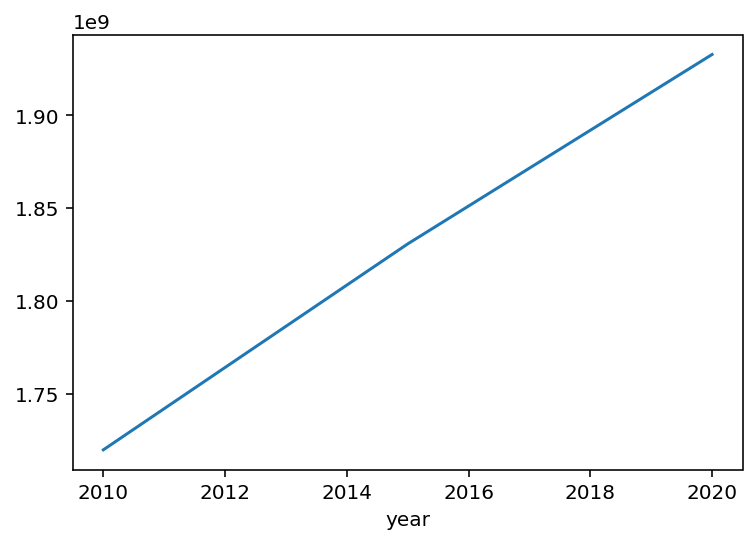

In [24]:
dfEP.groupby('year')['pop'].sum().plot()

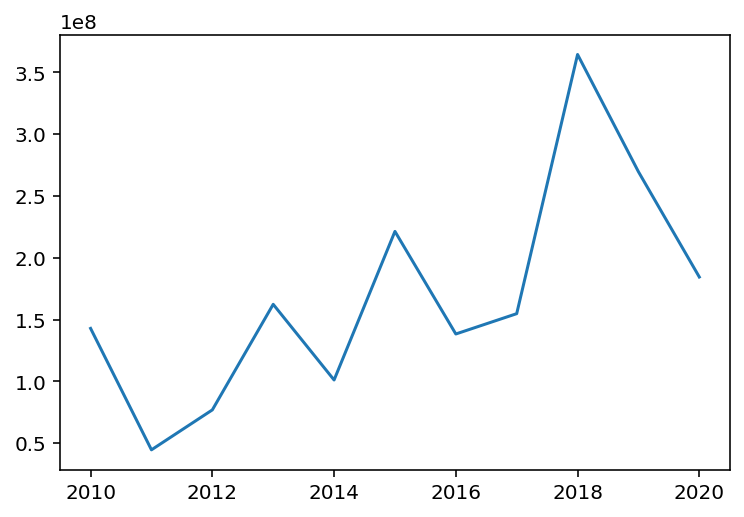

In [36]:
import pylab as plt
plt.plot(years, EP)

In [33]:
'projects/ee-thermopolis-revision/assets/population_%d'%year

'projects/ee-thermopolis-revision/assets/population_2020'